# Analyze Representations in Path-Integrating Recurrent Neural Networks

## Set Up + Imports

In [1]:
import setup

setup.main()
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import os

import matplotlib.pyplot as plt
import numpy as np
import skdim

import neurometry.datasets.synthetic as synthetic

os.environ["GEOMSTATS_BACKEND"] = "pytorch"

Working directory:  /home/facosta/neurometry/neurometry
Directory added to path:  /home/facosta/neurometry
Directory added to path:  /home/facosta/neurometry/neurometry


INFO:root:Using pytorch backend
INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


## Single-Agent RNN

### Load activations across training epochs

In [6]:
import sys

path = os.getcwd() + "/datasets/rnn_grid_cells"
sys.path.append(path)
from neurometry.datasets.load_rnn_grid_cells import load_activations

In [29]:
epochs = list(range(0, 100, 5))
(
    single_agent_activations,
    single_agent_rate_maps,
    single_agent_state_points,
) = load_activations(epochs, version="single", verbose=True)

Epoch 0 found!!! :D
Epoch 5 found!!! :D
Epoch 10 found!!! :D
Epoch 15 found!!! :D
Epoch 20 found!!! :D
Epoch 25 found!!! :D
Epoch 30 found!!! :D
Epoch 35 found!!! :D
Epoch 40 found!!! :D
Epoch 45 found!!! :D
Epoch 50 found!!! :D
Epoch 55 found!!! :D
Epoch 60 found!!! :D
Epoch 65 found!!! :D
Epoch 70 found!!! :D
Epoch 75 found!!! :D
Epoch 80 found!!! :D
Epoch 85 found!!! :D
Epoch 90 found!!! :D
Epoch 95 found!!! :D
Loaded epochs [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95] of single agent model.
There are 4096 grid cells with 20 x 20 environment resolution, averaged over 50 trajectories.
There are 20000 data points in the 4096-dimensional state space.
There are 400 data points averaged over 50 trajectories in the 4096-dimensional state space.


### Plot final activations

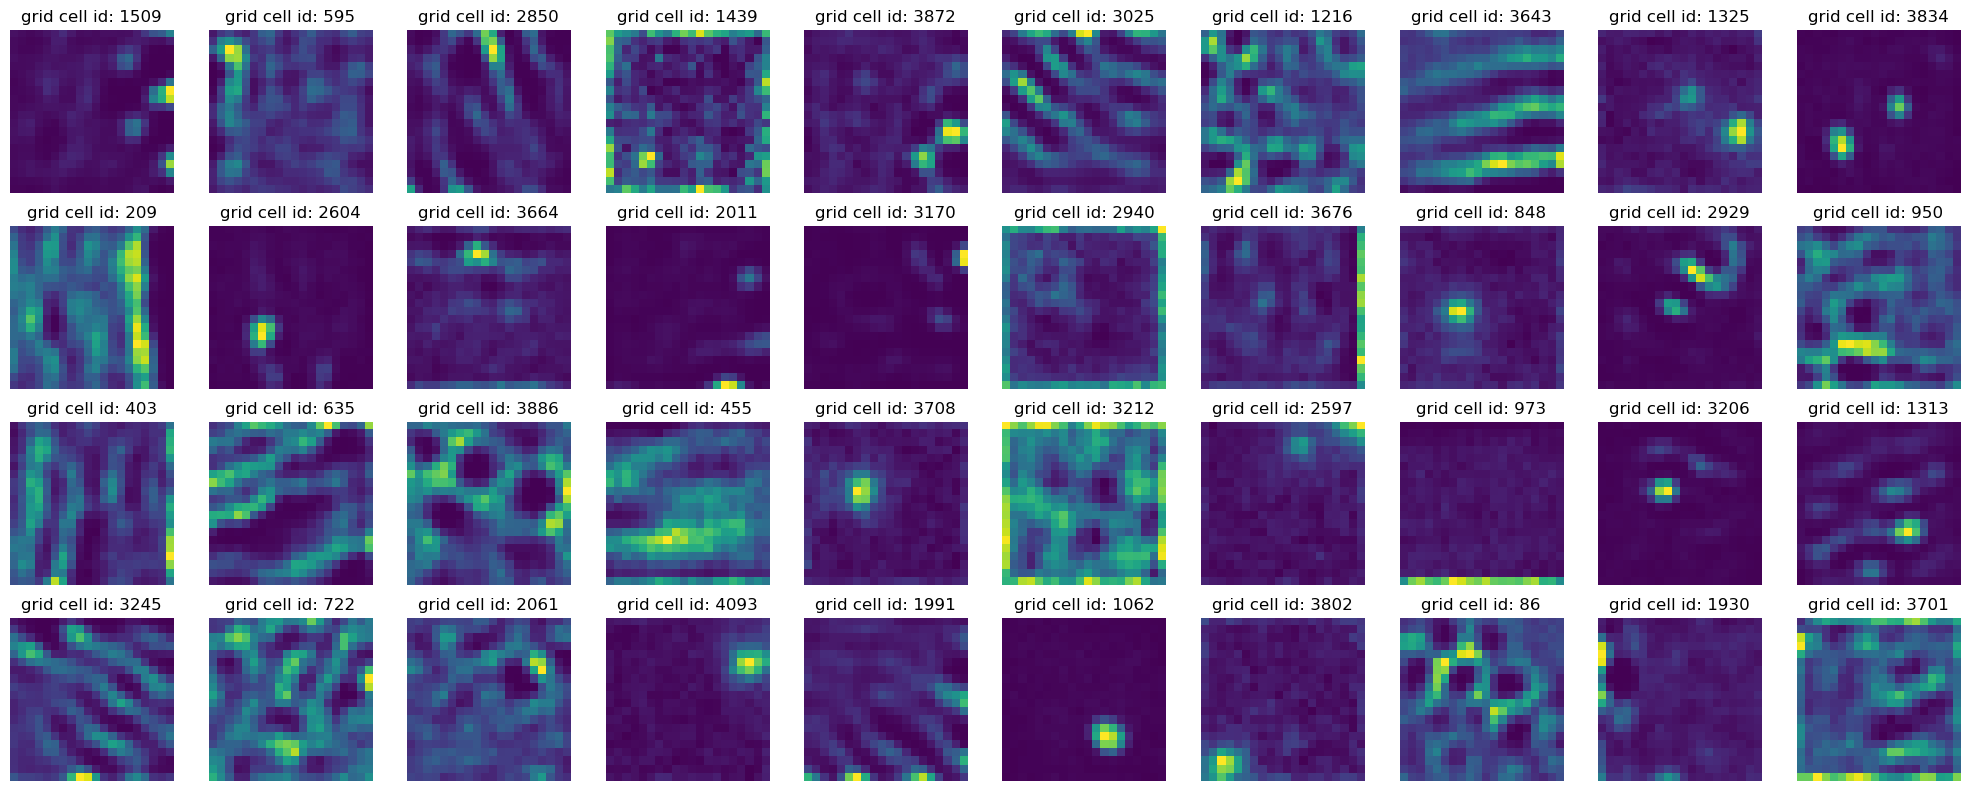

In [28]:
from neurometry.datasets.load_rnn_grid_cells import plot_rate_map

plot_rate_map(40, single_agent_activations[-1])

### Compute Persistent Homology

In [78]:
from gtda.diagrams import PairwiseDistance
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram

Load synthetic 2-torus

In [89]:
num_points = single_agent_rate_maps[0].T.shape[0]
embedding_dim = single_agent_rate_maps[0].T.shape[1]

task_points = synthetic.hypertorus(intrinsic_dim=2, num_points=num_points)

_, torus_points = synthetic.synthetic_neural_manifold(
    points=task_points,
    encoding_dim=embedding_dim,
    nonlinearity="linear",
)

norm_torus_points = torus_points / np.linalg.norm(torus_points, axis=1)[:, None]

WARNING! Poisson spikes not generated: mean must be non-negative


Load activation manifolds at epoch = 0  and epoch = 95

In [90]:
representations = [norm_torus_points]

for rep in single_agent_rate_maps:
    points = rep.T
    norm_points = points / np.linalg.norm(points, axis=1)[:, None]
    representations.append(norm_points)

Compute Vietoris-Rips persistence diagrams

In [92]:
homology_dimensions = (0, 1, 2)

# Compute the persistence diagrams
VR = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

vr_diagrams = VR.fit_transform(representations)

Compute pairwise bottleneck distance

In [93]:
PD = PairwiseDistance(metric="bottleneck", n_jobs=-1)

distance = PD.fit_transform(vr_diagrams)

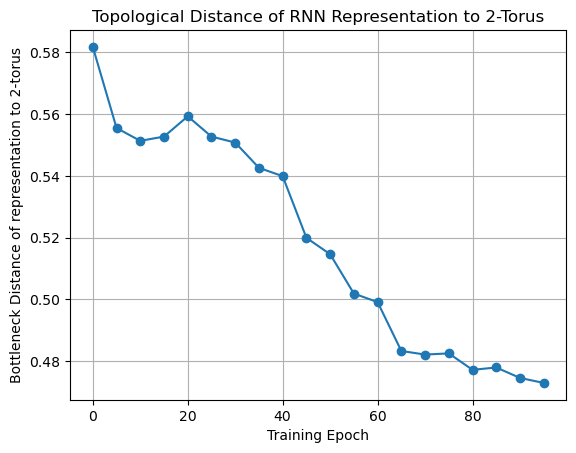

In [111]:
error = distance[0, 1:]
plt.plot(epochs, error, "o-")
plt.xlabel("Training Epoch")
plt.ylabel("Bottleneck Distance of representation to 2-torus")
plt.title("Topological Distance of RNN Representation to 2-Torus")
plt.grid();

In [173]:
model_folder = "Single agent path integration/Seed 1 weight decay 1e-06/"
model_parameters = "steps_20_batch_200_RNN_4096_relu_rf_012_DoG_True_periodic_False_lr_00001_weight_decay_1e-06/"

loss_path = (
    os.getcwd()
    + "/datasets/rnn_grid_cells/"
    + model_folder
    + model_parameters
    + "loss.npy"
)

loss = np.load(loss_path)

loss_aggregated = np.mean(loss.reshape(-1, 1000), axis=1)

In [174]:
PD = PairwiseDistance(metric="landscape", n_jobs=-1)

distance = PD.fit_transform(vr_diagrams)

error = distance[0, 1:]

In [175]:
error_normalized = (error - np.min(error)) / (np.max(error) - np.min(error))
loss_normalized = (loss_aggregated - np.min(loss_aggregated)) / (
    np.max(loss_aggregated) - np.min(loss_aggregated)
)

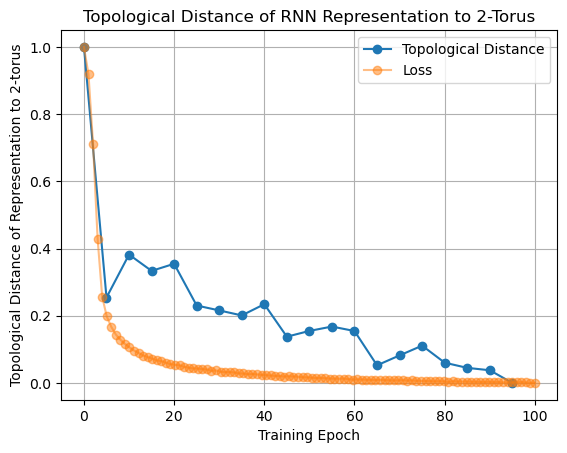

In [179]:
plt.plot(epochs, error_normalized, "o-", label="Topological Distance")
plt.plot(np.linspace(0, 100, 100), loss_normalized, "o-", alpha=0.5, label="Loss")
plt.xlabel("Training Epoch")
plt.ylabel("Topological Distance of Representation to 2-torus")
plt.title("Topological Distance of RNN Representation to 2-Torus")
plt.grid()
plt.legend();

In [115]:
fig_torus = plot_diagram(
    vr_diagrams[0],
    homology_dimensions=(0, 1, 2),
    plotly_params={"title": "VR PD, epoch=0"},
)
fig_torus.update_layout(title="VR PD, epoch=0")

In [113]:
fig_epoch_0 = plot_diagram(
    vr_diagrams[1],
    homology_dimensions=(0, 1, 2),
    plotly_params={"title": "VR PD, epoch=0"},
)
fig_epoch_0.update_layout(title="VR PD, epoch=0")

In [114]:
fig_epoch_95 = plot_diagram(
    vr_diagrams[-1],
    homology_dimensions=(0, 1, 2),
    plotly_params={"title": "VR PD, epoch=95"},
)
fig_epoch_95.update_layout(title="VR PD, epoch=95")

## Dual-Agent RNN

### Load activations across training epochs

In [30]:
epochs = list(range(0, 100, 5))
(
    dual_agent_activations,
    dual_agent_rate_maps,
    dual_agent_state_points,
) = load_activations(epochs, version="dual", verbose=True)

Epoch 0 found!!! :D
Epoch 5 found!!! :D
Epoch 10 found!!! :D
Epoch 15 found!!! :D
Epoch 20 found!!! :D
Epoch 25 found!!! :D
Epoch 30 found!!! :D
Epoch 35 found!!! :D
Epoch 40 found!!! :D
Epoch 45 found!!! :D
Epoch 50 found!!! :D
Epoch 55 found!!! :D
Epoch 60 found!!! :D
Epoch 65 found!!! :D
Epoch 70 found!!! :D
Epoch 75 found!!! :D
Epoch 80 found!!! :D
Epoch 85 found!!! :D
Epoch 90 found!!! :D
Epoch 95 found!!! :D
Loaded epochs [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95] of dual agent model.
There are 4096 grid cells with 20 x 20 environment resolution, averaged over 50 trajectories.
There are 20000 data points in the 4096-dimensional state space.
There are 400 data points averaged over 50 trajectories in the 4096-dimensional state space.


### Plot final activations

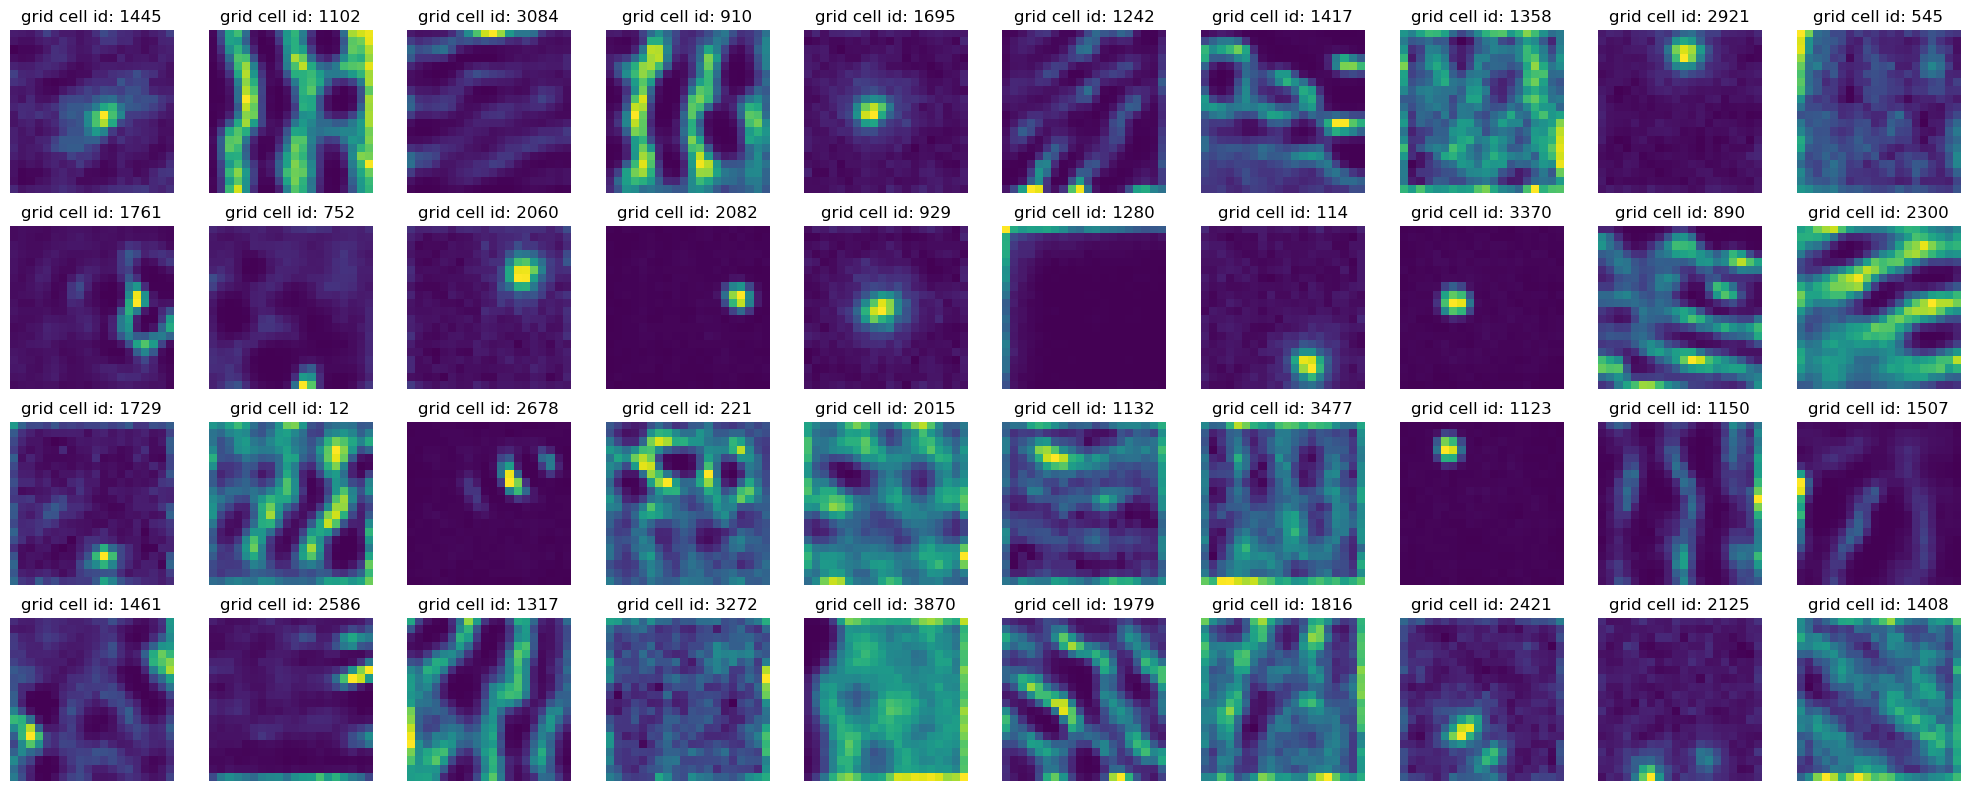

In [31]:
plot_rate_map(40, dual_agent_activations[-1])

### Estimate Dimension

In [3]:
neural_manifold = rate_maps.T


num_trials = 10
# methods = [method for method in dir(skdim.id) if not method.startswith("_")]
methods = ["MLE", "KNN", "TwoNN", "CorrInt", "lPCA"]

id_estimates = {}
for method_name in methods:
    method = getattr(skdim.id, method_name)()
    estimates = np.zeros(num_trials)
    for trial_idx in range(num_trials):
        method.fit(neural_manifold)
        estimates[trial_idx] = np.mean(method.dimension_)
    id_estimates[method_name] = estimates

In [6]:
neural_manifold.shape

(400, 4096)

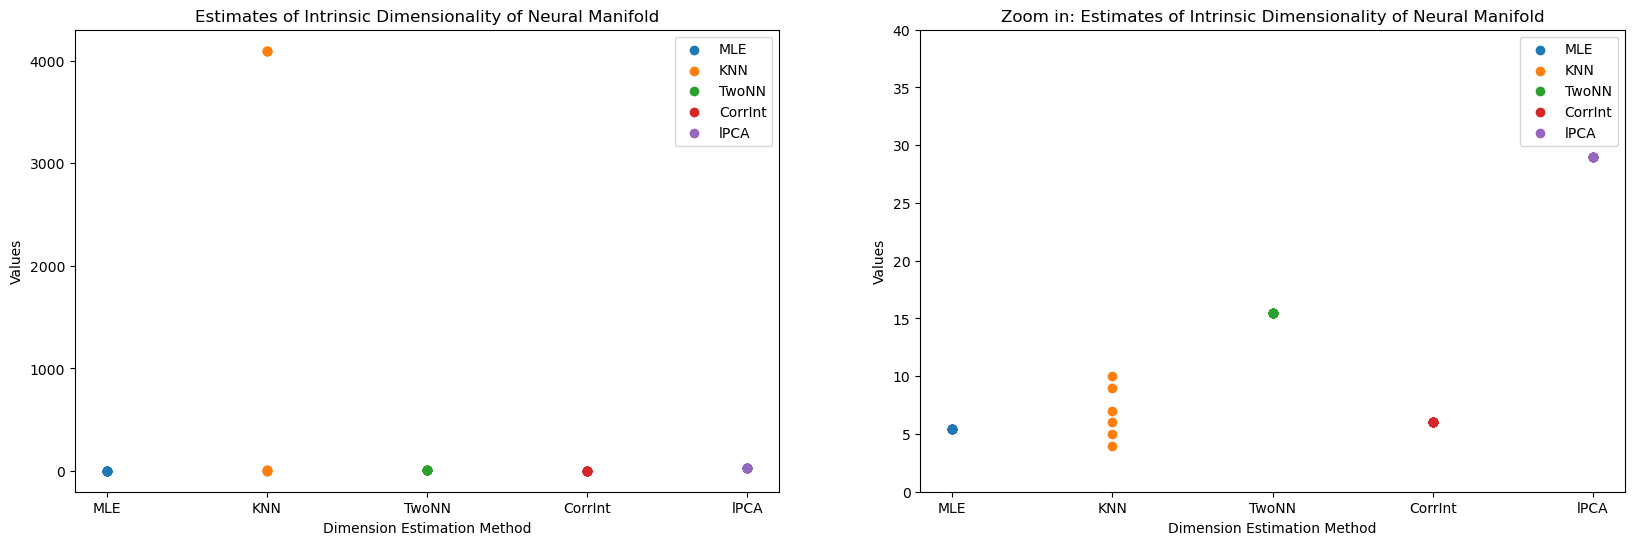

In [18]:
# make side by side plots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for i, method in enumerate(methods):
    y = id_estimates[method]
    x = np.repeat(i, len(y))
    axes[0].scatter(x, y, label=method)
    axes[1].scatter(x, y, label=method)

axes[0].set_xticks(range(len(methods)))
axes[0].set_xticklabels(methods)
axes[0].set_xlabel("Dimension Estimation Method")
axes[0].set_ylabel("Values")
axes[0].set_title("Estimates of Intrinsic Dimensionality of Neural Manifold")
axes[0].legend()

axes[1].set_xticks(range(len(methods)))
axes[1].set_xticklabels(methods)
axes[1].set_xlabel("Dimension Estimation Method")
axes[1].set_ylabel("Values")
axes[1].set_ylim([0, 40])
axes[1].set_title("Zoom in: Estimates of Intrinsic Dimensionality of Neural Manifold")
axes[1].legend();

estimate extrinsic with PCA, then do nonlinear dim est

### Estimate Topology

'compute_persistence_diagrams' executed in 1.1178s


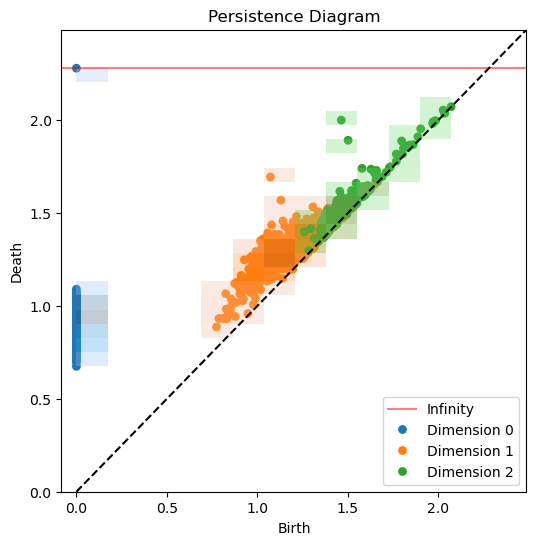

In [19]:
import neurometry.curvature.persistent_homology as persistent_homology
import neurometry.curvature.viz as viz

diagrams = persistent_homology.compute_persistence_diagrams(
    neural_manifold, maxdim=2, n_threads=-1
)


viz.plot_persistence_diagrams(diagrams, density=True)

'compute_persistence_diagrams' executed in 1.0917s


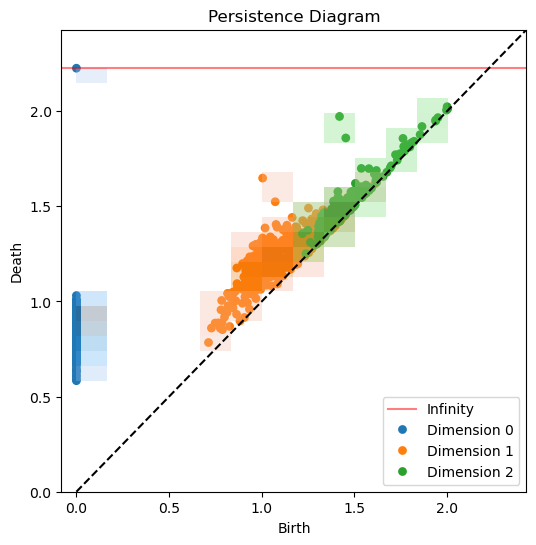

In [20]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
pca.fit(neural_manifold)
# project data onto principal components
pc = pca.transform(neural_manifold)

diagrams = persistent_homology.compute_persistence_diagrams(pc, maxdim=2, n_threads=-1)


viz.plot_persistence_diagrams(diagrams, density=True)